In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# EDA

In [2]:
path = './understanding_cloud_organization'

train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [3]:
train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'count images in train: {n_train}')
print(f'count images in test: {n_test}')

count images in train: 5546
count images in test: 3698


In [5]:
train['Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Image_Label
Fish      5546
Flower    5546
Gravel    5546
Sugar     5546
Name: count, dtype: int64

Кол-во картинок классов

In [6]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x : x.split('_')[1]).value_counts()

Image_Label
Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: count, dtype: int64

Кол-во картинок с определенным числом масок

In [7]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x : x.split('_')[0]).value_counts().value_counts()

count
2    2372
3    1560
1    1348
4     266
Name: count, dtype: int64

# Preprocessing

In [8]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

In [9]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0])
id_mask_count = id_mask_count.value_counts().reset_index().rename(columns={'Image_Label': 'im_id', 'count': 'count'})
id_mask_count

,im_id,count
0,24dd99c.jpg,4
1,562f80a.jpg,4
2,944f10b.jpg,4
3,55b539f.jpg,4
4,cdf7242.jpg,4
...,...,...
5541,4cce343.jpg,1
5542,4cd1196.jpg,1
5543,4ce7229.jpg,1
5544,4d07564.jpg,1


In [10]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(id_mask_count['im_id'].values, stratify=id_mask_count['count'], random_state=RANDOM_SEED, test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

train_ids

array(['8bc5e41.jpg', '90e37a7.jpg', '25d78ce.jpg', ..., '07c3377.jpg',
       '56609dc.jpg', '8cd8f5b.jpg'], dtype=object)

In [11]:
def get_image(x, folder='train_images'):
    data_folder = f'{path}/{folder}'
    image_path = os.path.join(data_folder, x)
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def decode_mask(mask_code, shape=(1400, 2100)):
    s = mask_code.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df, image_name='img.jpg', shape=(1400, 2100)):
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for i, label in enumerate(encoded_masks.values):
        if label is np.nan:
            continue
        mask = decode_mask(label)
        masks[:, :, i] = mask

    return masks


def pixel_number_to_coordinate(num, width):
    x = num // width
    y = num % width
    return x, y


def decode_box(mask_code, shape=(1400, 2100)):
    s = mask_code.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    x_min, y_min = pixel_number_to_coordinate(starts[0], shape[0])
    x_max, y_max = pixel_number_to_coordinate(ends[len(ends) - 1], shape[0])
    return np.array([x_min, y_min, x_max, y_max]) / 7


def make_boxes(df, image_name='im_id', shpae=(1400, 2100)):
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    boxes = np.zeros((4, 4), dtype=np.float32)

    for i, label in enumerate(encoded_masks.values):
        if label is np.nan:
            continue
        box = decode_box(label)
        boxes[:, i] = box

    return boxes.T

def visualize(image, mask):
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(1, 5, figsize=(24, 24))
    ax[0].imshow(image)
    for i in range(4):
        ax[i + 1].imshow(mask[:, :, i])
        ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)

def multi_hot_encode(df, image_name):
    multi_hot = torch.zeros(4, dtype=torch.long)
    labels = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    for i, label in enumerate(labels.values):
        if label is np.nan:
            continue
        multi_hot[i] = 1
    return multi_hot

multi-label: tensor([0, 0, 0, 1])


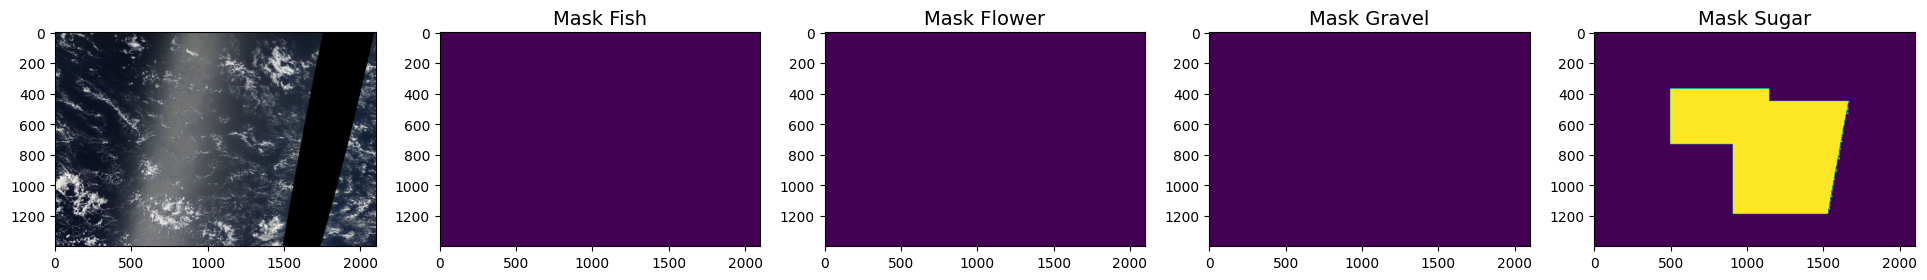

In [12]:
image_name = '4cce343.jpg'
image = get_image(image_name)
mask = make_mask(train, image_name)
print('multi-label:', multi_hot_encode(train, image_name))

visualize(image, mask)

In [13]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CloudDataset(Dataset):
    def __init__(self, df, datatype, img_ids, transforms, preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f'{path}/train_images'
        else:
            self.data_folder = f'{path}/test_images'
        self.img_ids = img_ids
        self.prepocessing = preprocessing
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        labels = multi_hot_encode(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        image = Image.open(image_path).convert("RGB")
        return self.transforms(image).to(device), labels.to(device)

    def __len__(self):
        return len(self.img_ids)

In [14]:
import torchvision.transforms as transforms

batch_size = 16

from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

test_dataset = CloudDataset(df=sub, datatype='test', img_ids=test_ids, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

image, label = train_dataset[0]
print(image, label)

tensor([[[ 0.5878,  1.6153,  1.8722,  ..., -0.7308,  0.5707,  1.0844],
         [ 0.4166,  0.5193,  0.3138,  ..., -0.8507, -0.7137, -0.2684],
         [-0.8164, -1.5870, -1.6213,  ..., -1.2959, -1.3473, -1.3302],
         ...,
         [-0.2856,  0.0227, -0.0287,  ...,  1.6495,  1.6667,  1.5468],
         [-0.5938, -0.4054, -0.5938,  ...,  1.6324,  1.6324,  1.5297],
         [ 0.5536, -0.4054, -0.2171,  ...,  1.7180,  1.7523,  1.7009]],

        [[ 0.8004,  1.8508,  2.1660,  ..., -0.5651,  0.7829,  1.3081],
         [ 0.6779,  0.7829,  0.5728,  ..., -0.6877, -0.5301, -0.0749],
         [-0.6001, -1.3880, -1.4230,  ..., -1.1429, -1.1779, -1.1604],
         ...,
         [-0.0399,  0.2227,  0.1702,  ...,  1.7983,  1.8158,  1.6933],
         [-0.3375, -0.1975, -0.4076,  ...,  1.7808,  1.7808,  1.6758],
         [ 0.8354, -0.1975, -0.0224,  ...,  1.8683,  1.9034,  1.8508]],

        [[ 1.2108,  2.2566,  2.5180,  ..., -0.2532,  1.0191,  1.5768],
         [ 1.0714,  1.1759,  0.9668,  ..., -0

## Модель

In [15]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 4)
model.to(device)

/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities
        inputs = torch.sigmoid(inputs)
        
        # Flatten the inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate the intersection
        intersection = (inputs * targets).sum()
        
        # Calculate the Dice coefficient
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        # Return Dice loss (1 - Dice coefficient)
        return 1 - dice

In [17]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters())

In [18]:
num_epochs = 10
patience = 3

train_losses = []
val_losses = []

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        conf_preds = model(images)

        loss = criterion(conf_preds, labels.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            conf_preds = model(images)

            loss = criterion(conf_preds, labels.float())

            val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss <= best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
          best_model_wts = model.state_dict()
          torch.save(best_model_wts, 'model.pth')
        else:
          patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

100%|██████████| 231/231 [04:21<00:00,  1.13s/it]


Epoch 1/10
Train Loss: 0.3044
Val Loss: 0.0334


100%|██████████| 231/231 [03:27<00:00,  1.11it/s]


Epoch 2/10
Train Loss: 0.2997
Val Loss: 0.0450


100%|██████████| 231/231 [03:29<00:00,  1.10it/s]


Epoch 3/10
Train Loss: 0.2991
Val Loss: 0.0280


100%|██████████| 231/231 [03:30<00:00,  1.10it/s]


Epoch 4/10
Train Loss: 0.2974
Val Loss: 0.0235


100%|██████████| 231/231 [04:07<00:00,  1.07s/it]


Epoch 5/10
Train Loss: 0.2984
Val Loss: 0.0299


100%|██████████| 231/231 [03:04<00:00,  1.25it/s]


Epoch 6/10
Train Loss: 0.2971
Val Loss: 0.0604


100%|██████████| 231/231 [02:47<00:00,  1.38it/s]


Epoch 7/10
Train Loss: 0.3005
Val Loss: 0.0220


100%|██████████| 231/231 [02:44<00:00,  1.40it/s]


Epoch 8/10
Train Loss: 0.2968
Val Loss: 0.0254


100%|██████████| 231/231 [02:57<00:00,  1.30it/s]


Epoch 9/10
Train Loss: 0.3064
Val Loss: 0.0145


100%|██████████| 231/231 [03:21<00:00,  1.15it/s]


Epoch 10/10
Train Loss: 0.3042
Val Loss: 0.0032


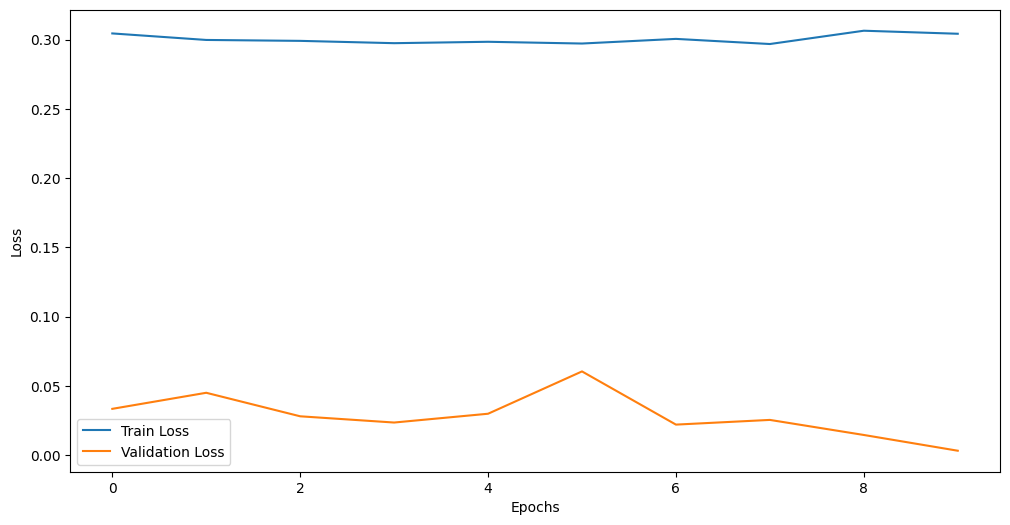

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Оценка качества

In [22]:
from torchmetrics.classification import Dice

valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms=transform)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)

model.load_state_dict(torch.load('model.pth'))
model.eval()

with torch.no_grad():
    y = []
    y_pred = []

    for image, label in tqdm(valid_loader):
        y_pred.append(model(image))
        y.append(label)

    y = torch.cat(y)
    y_pred = torch.cat(y_pred)

    dice = Dice(average='micro')
    print(dice(y_pred, y))

100%|██████████| 555/555 [00:44<00:00, 12.40it/s]

tensor(0.6963)
